In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine,reflect = True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
earlieststr = session.query(measurement.date).order_by(measurement.date).first()
lateststr = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"Latest Date: {lateststr[0]}")

latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
lastyear = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
lastyear

sel = [measurement.date,measurement.prcp]

query_result = session.query(*sel).filter(measurement.date >= lastyear).all()

precipitation = pd.DataFrame(query_result, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any')
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation

Latest Date: 2017-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


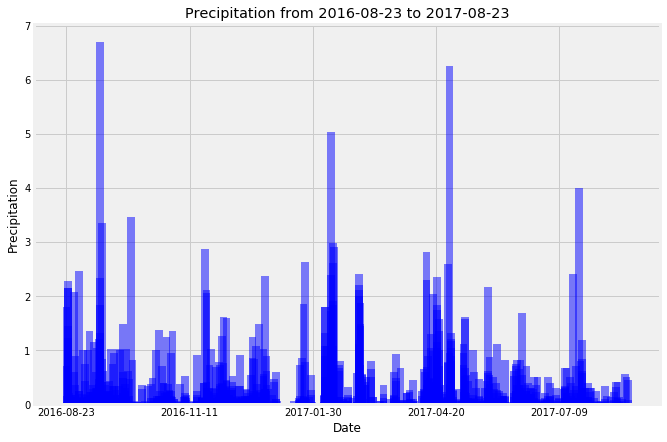

In [16]:
x = precipitation.index.tolist()
y = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(x,y,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation') 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {lastyear} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', linestyle='-')

plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
session.query(station.id).count() #Amount of stations available in dataset

9

In [19]:
sel = [measurement.station,func.count(measurement.id)]

most_active_stations = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
most_active_stations # list of the most active stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
sel = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]

most_active_station_record = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.id).desc()).first()

#most_active_station_record

print(f"Lowest Temperature: {most_active_station_record[0]}") #Lowest temperature recorded in the most active atation
print(f"Highest Temperature: {most_active_station_record[1]}") #Highest temperature recorded in the most active atation
print(f"Average Teperature: {most_active_station_record[2]}") #Average temperature recorded in the most active atation

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Teperature: 71.66378066378067


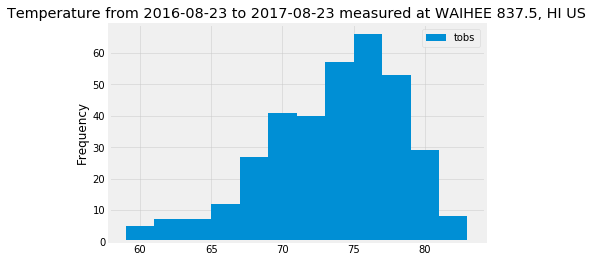

In [25]:
query_result = session.query(measurement.tobs).filter(measurement.station == most_active_stations[0][0]).filter(measurement.date >= lastyear).all()
temperatures = list(np.ravel(query_result))

sel = [station.station,station.name,station.latitude,station.longitude,station.elevation]
query_result = session.query(*sel).all()
stations = pd.DataFrame(query_result, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = stations.loc[stations["Station"] == most_active_stations[0][0],"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.5)
plt.ylabel('Frequency')
plt.title(f"Temperature from {lastyear} to {lateststr[0]} measured at {station_name}")

plt.legend()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
